## Imports

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')
from utils.loading import load_table
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import numpy as np
import time
import tensorflow as tf
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import regularizers
pd.set_option('display.max_rows', 4000)
import warnings
pd.set_option('mode.chained_assignment', None)
from tqdm.auto import tqdm
tqdm.pandas()

2023-05-19 13:39:54.982437: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Tables Dict


In [29]:
# Dictionary of 'table_name' -> []'patient', 'datetime']
tables = {
    'Meter': ['DeidentID', 'DataDtTm'],
    'CGM': ['DeidentID', 'DisplayTime'],
    'CGMCal': ['DeidentID', 'DisplayTime'],
    'Ketone': ['DeidentID', 'DataDtTm'],
    'MonitorBasalBolus': ['DeidentID', 'LocalDeliveredDtTm'],
    'MonitorCGM': ['DeidentID', 'LocalDtTmAdjusted'],
    'MonitorCorrectionBolus': ['DeidentID', 'LocalDeliveredDtTm'],
    'MonitorMeal': ['DeidentID', 'LocalDtTm'],
    'MonitorMealBolus': ['DeidentID', 'LocalDeliveredDtTm'],
    'MonitorSMBG': ['DeidentID','LocalDtTm'],
    'MonitorSystem': ['DeidentID','LocalDtTm'],
    'MonitorTotalBolus': ['DeidentID', 'LocalDeliveredDtTm'],
    'Pump': ['DeidentID', 'DataDtTm'],
}
GROUP_DATES = True

## Load Relevant Tables

In [30]:
df_MonitorBasalBolus = load_table(filename='MonitorBasalBolus', date_cols=tables['MonitorBasalBolus'])
df_MonitorCGM = load_table(filename='MonitorCGM', date_cols=tables['MonitorCGM'])
df_MonitorCorrectionBolus = load_table(filename='MonitorCorrectionBolus', date_cols=tables['MonitorCorrectionBolus'])
df_MonitorMeal = load_table(filename='MonitorMeal', date_cols=tables['MonitorMeal'])
df_MonitorMealBolus = load_table(filename='MonitorMealBolus', date_cols=tables['MonitorMealBolus'])
df_MonitorSMBG = load_table(filename='MonitorSMBG', date_cols=tables['MonitorSMBG'])
df_MonitorSystem = load_table(filename='MonitorSystem', date_cols=tables['MonitorSystem'])
df_MonitorTotalBolus = load_table(filename='MonitorTotalBolus', date_cols=tables['MonitorTotalBolus'])

## Remove unnecessary entries

In [31]:
df_MonitorBasalBolus = df_MonitorBasalBolus[['DeidentID','LocalDeliveredDtTm', 'DeliveredValue']]
df_MonitorCGM = df_MonitorCGM[['DeidentID','LocalDtTm', 'CGM']]
df_MonitorCorrectionBolus = df_MonitorCorrectionBolus[['DeidentID','LocalDeliveredDtTm', 'BolusSource', 'DeliveredValue']]
df_MonitorMeal = df_MonitorMeal[['DeidentID','LocalDtTm', 'MealSize', 'SMBG']]
df_MonitorMealBolus = df_MonitorMealBolus[['DeidentID','LocalDeliveredDtTm', 'DeliveredValue']]
df_MonitorSMBG = df_MonitorSMBG[df_MonitorSMBG['IsCalibration'] == 0]
df_MonitorSMBG = df_MonitorSMBG[['DeidentID','LocalDtTm', 'SMBG', 'IsHypo', 'DidTreat', 'Carbs']]
df_MonitorSystem = df_MonitorSystem[['DeidentID','LocalDtTm', 'DiAsState', 'IOBValue', 'Hypolight', 'Hyperlight', 'Exercising']]
df_MonitorTotalBolus = df_MonitorTotalBolus[['DeidentID','LocalDeliveredDtTm', 'DeliveredValue']]

## Standardize Naming

In [32]:
df_MonitorCorrectionBolus['LocalDtTm'] = df_MonitorCorrectionBolus['LocalDeliveredDtTm']
df_MonitorMealBolus['LocalDtTm'] = df_MonitorMealBolus['LocalDeliveredDtTm']
df_MonitorTotalBolus['LocalDtTm'] = df_MonitorTotalBolus['LocalDeliveredDtTm']
df_MonitorBasalBolus['LocalDtTm'] = df_MonitorBasalBolus['LocalDeliveredDtTm']
df_MonitorCorrectionBolus.drop(columns=['LocalDeliveredDtTm'], inplace=True)
df_MonitorMealBolus.drop(columns=['LocalDeliveredDtTm'], inplace=True)
df_MonitorTotalBolus.drop(columns=['LocalDeliveredDtTm'], inplace=True)
df_MonitorBasalBolus.drop(columns=['LocalDeliveredDtTm'], inplace=True)

## Create one large insuline DataFrame

In [33]:
df_Insulin = pd.concat([df_MonitorBasalBolus, df_MonitorCorrectionBolus, df_MonitorMealBolus])
df_Insulin = df_Insulin.sort_values(by='LocalDtTm', ascending=True)
df_Insulin = df_Insulin.reset_index(drop=True)
df_Insulin = df_Insulin[['LocalDtTm', 'DeliveredValue', 'DeidentID']]

## Remove data with insufficient coverage

In [34]:
# make LocalDtTm a DateTime
df_MonitorCGM['LocalDtTm'] = pd.to_datetime(df_MonitorCGM['LocalDtTm'])

def get_hourly_coverage(df, date_col, patient_col, threshold):

    df = df.copy(deep=True).sort_values(date_col).set_index([date_col])
    df.DeidentID = df.DeidentID.astype(int)


    df = df.groupby(patient_col, as_index=True).resample('1H', level=date_col)[[patient_col]].count()
    df.rename(columns={patient_col: 'Entries'}, inplace=True)
    df.reset_index(inplace=True)
    df.rename(columns={'level_0': patient_col}, inplace=True)

    df = df.groupby(patient_col, as_index=False).rolling(window=24, on=date_col, closed='right').sum()
    df['covered'] = df.Entries>threshold
    return df

investigation_tables = {
    'Insuline': (df_Insulin, 0),
    'MonitorCGM': (df_MonitorCGM, 220)
}
result_tables = {}
for table in investigation_tables.keys():
    df = get_hourly_coverage(investigation_tables[table][0], 'LocalDtTm', 'DeidentID', investigation_tables[table][1])
    result_tables[table] = df
    fig = px.histogram(df.Entries, title=table, color=df.covered)
    fig.show()

first_df = list(result_tables.keys())[0]
res_df = result_tables[first_df]
res_df.rename(columns={'covered': f'covered_{first_df}'}, inplace=True)

for table in list(result_tables.keys())[1:]:
    res_df = res_df.merge(result_tables[table], on=['DeidentID', 'LocalDtTm'], how='outer', suffixes=('', f'_{table}'))
    res_df.rename(columns={'covered': f'covered_{table}'}, inplace=True)
res_df

covered_cols = [x for x in res_df.columns if 'covered' in x]
res_df['all_covered'] = res_df[covered_cols].fillna(False).all(axis=1)
print(res_df.all_covered.value_counts())

all_covered
True     73827
False    62495
Name: count, dtype: int64


## Select Patient

In [35]:
DeidentId = '2'
# filter by patient
df_MonitorBasalBolus = df_MonitorBasalBolus[df_MonitorBasalBolus['DeidentID'] == DeidentId]
df_MonitorCGM = df_MonitorCGM[df_MonitorCGM['DeidentID'] == DeidentId]
df_MonitorCorrectionBolus = df_MonitorCorrectionBolus[df_MonitorCorrectionBolus['DeidentID'] == DeidentId]
df_MonitorMeal = df_MonitorMeal[df_MonitorMeal['DeidentID'] == DeidentId]
df_MonitorMealBolus = df_MonitorMealBolus[df_MonitorMealBolus['DeidentID'] == DeidentId]
df_MonitorSMBG = df_MonitorSMBG[df_MonitorSMBG['DeidentID'] == DeidentId]
df_MonitorSystem = df_MonitorSystem[df_MonitorSystem['DeidentID'] == DeidentId]
df_MonitorTotalBolus = df_MonitorTotalBolus[df_MonitorTotalBolus['DeidentID'] == DeidentId]
df_Insulin = df_Insulin[df_Insulin['DeidentID'] == DeidentId]
res_df = res_df[res_df['DeidentID'] == int(DeidentId)]

In [36]:
print(res_df)

       DeidentID           LocalDtTm  Entries covered_Insuline   
1716           2 2013-11-09 11:00:00      NaN            False  \
1717           2 2013-11-09 12:00:00      NaN            False   
1718           2 2013-11-09 13:00:00      NaN            False   
1719           2 2013-11-09 14:00:00      NaN            False   
1720           2 2013-11-09 15:00:00      NaN            False   
...          ...                 ...      ...              ...   
10068          2 2014-10-23 11:00:00    203.0             True   
10069          2 2014-10-23 12:00:00    207.0             True   
10070          2 2014-10-23 13:00:00    207.0             True   
10071          2 2014-10-23 14:00:00    210.0             True   
10072          2 2014-10-23 15:00:00    205.0             True   

       Entries_MonitorCGM covered_MonitorCGM  all_covered  
1716                  NaN                NaN        False  
1717                  NaN                NaN        False  
1718                  NaN  

## Remove Rows without coverage

In [37]:
# filter df_MonitorCGM to only contain rows whose LocalDtTm is within 1 hour of any row in res_df
res_df = res_df[res_df['all_covered'] == True]
#sort dfs by local time
df_MonitorCGM = df_MonitorCGM.sort_values(by='LocalDtTm', ascending=True)
res_df = res_df.sort_values(by='LocalDtTm', ascending=True)
# make LocalDtTm a DateTime
df_MonitorCGM['LocalDtTm'] = pd.to_datetime(df_MonitorCGM['LocalDtTm'])
res_df['LocalDtTm'] = pd.to_datetime(res_df['LocalDtTm'])
df_MonitorCGM['rounded'] = df_MonitorCGM['LocalDtTm'].dt.round('1H')
res_df['rounded'] = res_df['LocalDtTm'].dt.round('1H')
df_MonitorCGM = df_MonitorCGM[df_MonitorCGM['rounded'].isin(res_df['rounded'])]
df_MonitorCGM = df_MonitorCGM.drop(columns=['rounded'])

## Create 5-minute dataframes for aggregating

In [38]:
df_Insulin['LocalDtTm'] = df_Insulin['LocalDtTm'].dt.floor('5min')
df_Insulin_agg = df_Insulin.groupby('LocalDtTm')['DeliveredValue'].sum().astype(float)
df_MonitorSMBG['LocalDtTm'] = df_MonitorSMBG['LocalDtTm'].dt.floor('5min')
df_MonitorSMBG_agg = df_MonitorSMBG.groupby('LocalDtTm')['Carbs'].sum().astype(float)
df_MonitorMeal['LocalDtTm'] = df_MonitorMeal['LocalDtTm'].dt.floor('5min')
df_MonitorMeal_agg = df_MonitorMeal.groupby('LocalDtTm')['MealSize'].sum().astype(float)
df_MonitorSystem['LocalDtTm'] = df_MonitorSystem['LocalDtTm'].dt.floor('5min')
df_MonitorSystem_agg = df_MonitorSystem.groupby('LocalDtTm')['Exercising'].sum().astype(float)
#make Exercising binary
df_MonitorSystem_agg = df_MonitorSystem_agg.apply(lambda x: 1 if x > 0 else 0)
df_Insulin_agg = df_Insulin_agg.to_frame()
df_MonitorSMBG_agg = df_MonitorSMBG_agg.to_frame()
df_MonitorMeal_agg = df_MonitorMeal_agg.to_frame()
df_MonitorSystem_agg = df_MonitorSystem_agg.to_frame()

print(df_Insulin_agg)

                     DeliveredValue
LocalDtTm                          
2012-03-28 10:30:00             6.0
2012-03-28 10:45:00             1.5
2012-03-28 11:15:00             7.0
2012-03-28 11:20:00             0.1
2012-03-28 11:25:00             0.2
...                             ...
2015-08-04 07:50:00             0.1
2015-08-04 08:00:00             0.1
2015-08-04 08:35:00             0.1
2015-08-04 08:40:00             0.1
2015-08-04 08:45:00             0.1

[279229 rows x 1 columns]


## Function to group time series data by 5-minute intervals

In [39]:
def get_24_hour_bins(df, date, df_name):

    # filter the dataframe to keep only the rows within the past 24 hours
    df = df.loc[date-pd.Timedelta(days=1):date]
    # create a list of 288 values with 0 for any missing intervals
    date_range = pd.date_range(date - pd.Timedelta(days=1), date, freq='5min')
    date_range = date_range.floor('5min')
    #reverse the list
    date_range = date_range[::-1]
    # change date range type
    date_range = date_range.astype(str)
    # make date_range a list of strings
    date_range = date_range.tolist()
    # get the values from the dataframe
    if df_name == 'insulin':
        result = [df.DeliveredValue.get(dates, default=0) for dates in date_range]
    elif df_name == 'SMBG':
        result = [df.Carbs.get(dates, default=0) for dates in date_range]
    elif df_name == 'Meal':
        result = [df.MealSize.get(dates, default=0) for dates in date_range]
    elif df_name == 'System':
        result = [df.Exercising.get(dates, default=0) for dates in date_range]
    result = result[:288]
    return result

## test function

In [40]:
date = '2015-08-04 08:45:00'
date = pd.to_datetime(date)
print(get_24_hour_bins(df_Insulin_agg, date, 'insulin'))

[0.1000000014901161, 0.1000000014901161, 0.1000000014901161, 0, 0, 0, 0, 0, 0, 0.1000000014901161, 0, 0.1000000014901161, 0.1000000014901161, 0, 0.1000000014901161, 0.1000000014901161, 0.1000000014901161, 0, 0.1000000014901161, 0.1000000014901161, 0.1000000014901161, 0, 0.1000000014901161, 0.1000000014901161, 1.9999999776482582, 0.2000000029802322, 0.2000000029802322, 0.2000000029802322, 0.2000000029802322, 0.1000000014901161, 0.2000000029802322, 0.2000000029802322, 0.2000000029802322, 0.1000000014901161, 0.2000000029802322, 0.2000000029802322, 0.1000000014901161, 0.2000000029802322, 0.1000000014901161, 0.2000000029802322, 0.2000000029802322, 0.1000000014901161, 0.2000000029802322, 0.1000000014901161, 0.1000000014901161, 0.2000000029802322, 0.1000000014901161, 0.1000000014901161, 0.1000000014901161, 0, 0.1000000014901161, 0.1000000014901161, 1.3000000268220901, 0.3000000119209289, 0.2000000029802322, 0.3000000119209289, 0.2000000029802322, 0.2000000029802322, 0.2000000029802322, 0.2000

## Final DataFrame creation

In [41]:
df_final = pd.DataFrame()
df_final['LocalDtTm'] = df_MonitorCGM['LocalDtTm']
df_final['CGM'] = df_MonitorCGM['CGM']
df_final['LocalDtTm'] = pd.to_datetime(df_final['LocalDtTm'])
print('starting insuline calculation')
new_df_insuline = df_final['LocalDtTm'].progress_apply(lambda x: pd.Series(get_24_hour_bins(df_Insulin_agg, x, 'insulin')))
new_df_insuline.columns = [f"insulin {i}" for i in range(1, 289)]
print('insulin bins added')

starting insuline calculation


  0%|          | 0/56784 [00:00<?, ?it/s]

insulin bins added


In [42]:
print('starting meal calculation')
new_df_meal = df_final['LocalDtTm'].progress_apply(lambda x: pd.Series(get_24_hour_bins(df_MonitorMeal_agg, x, 'Meal')))
new_df_meal.columns = [f"mealsize {i}" for i in range(1, 289)]
print('meal bins added')

starting meal calculation


  0%|          | 0/56784 [00:00<?, ?it/s]

meal bins added


In [45]:
print('starting smbg calculation')
new_df_smbg = df_final['LocalDtTm'].progress_apply(lambda x: pd.Series(get_24_hour_bins(df_MonitorSMBG_agg, x, 'SMBG')))
new_df_smbg.columns = [f"carbs {i}" for i in range(1, 289)]
print('smbg bins added')

starting smbg calculation


  0%|          | 0/56784 [00:00<?, ?it/s]

smbg bins added


In [46]:
print('starting system calculation')
new_df_system = df_final['LocalDtTm'].progress_apply(lambda x: pd.Series(get_24_hour_bins(df_MonitorSystem_agg, x, 'System')))
new_df_system.columns = [f"exercise {i}" for i in range(1, 289)]
print('system bins added')

starting system calculation


  0%|          | 0/56784 [00:00<?, ?it/s]

system bins added


In [47]:
df_final = pd.concat([df_final, new_df_insuline, new_df_meal, new_df_smbg, new_df_system], axis=1)
df_final = df_final.dropna()
df_final = df_final.reset_index(drop=True)
df_final['LocalDtTm'] = pd.to_datetime(df_final['LocalDtTm'])
df_final = df_final.sort_values(by='LocalDtTm', ascending=True)

In [48]:
print(df_final.head())
print(df_final)
df_final.to_csv(f'df_final_{DeidentId}.csv', index=False)

            LocalDtTm  CGM  insulin 1  insulin 2  insulin 3  insulin 4   
0 2013-11-22 12:32:17  123        0.2        0.1        0.1        0.3  \
1 2013-11-22 12:37:17  110        4.3        0.2        0.1        0.1   
2 2013-11-22 12:42:17   92        0.1        4.3        0.2        0.1   
3 2013-11-22 12:47:17   82        0.2        0.1        4.3        0.2   
4 2013-11-22 12:52:17   76        0.0        0.2        0.1        4.3   

   insulin 5  insulin 6  insulin 7  insulin 8  ...  exercise 279   
0        0.1        0.1        0.1        0.1  ...             0  \
1        0.3        0.1        0.1        0.1  ...             0   
2        0.1        0.3        0.1        0.1  ...             0   
3        0.1        0.1        0.3        0.1  ...             0   
4        0.2        0.1        0.1        0.3  ...             0   

   exercise 280  exercise 281  exercise 282  exercise 283  exercise 284   
0             0             0             0             0             0

## Save the final DataFrame

In [ ]:
df_final.to_csv(f'df_final_{DeidentId}.csv', index=False)

## Build and Train Neural Network

2023-05-14 18:23:34.708580: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
95/95 [==============================] - 1s 4ms/step - loss: 20198.3359 - mae: 129.9716 - val_loss: 4671.0371 - val_mae: 54.9488
Epoch 2/100
95/95 [==============================] - 0s 2ms/step - loss: 8847.8330 - mae: 76.1825 - val_loss: 4281.1226 - val_mae: 54.6153
Epoch 3/100
95/95 [==============================] - 0s 2ms/step - loss: 7626.5005 - mae: 70.0315 - val_loss: 3713.7339 - val_mae: 50.1530
Epoch 4/100
95/95 [==============================] - 0s 2ms/step - loss: 6889.5015 - mae: 66.5522 - val_loss: 3488.5618 - val_mae: 48.3544
Epoch 5/100
95/95 [==============================] - 0s 2ms/step - loss: 6958.6069 - mae: 66.4262 - val_loss: 3375.0249 - val_mae: 47.5981
Epoch 6/100
95/95 [==============================] - 0s 2ms/step - loss: 6381.2544 - mae: 63.4927 - val_loss: 3226.3645 - val_mae: 46.1320
Epoch 7/100
95/95 [==============================] - 0s 2ms/step - loss: 6285.3145 - mae: 62.8068 - val_loss: 3488.8689 - val_mae: 49.0049
Epoch 8/100
95/95 [======

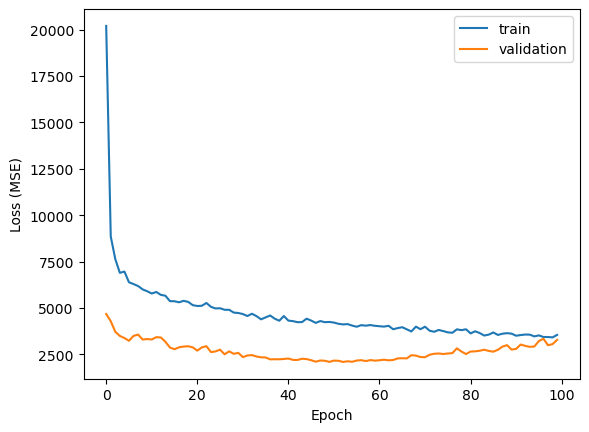

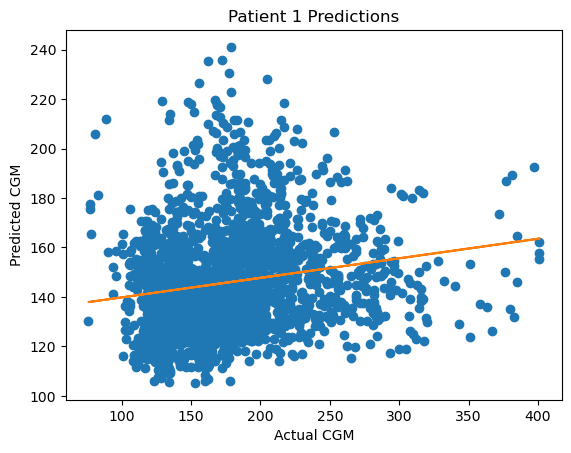

In [21]:
X = df_final.drop(columns='CGM')
X = X.drop(columns='LocalDtTm')
y = df_final['CGM']

# Split the data into training and testing sets
X_train = X[:int(0.8 * len(X))]
X_test = X[int(0.8 * len(X)):]
y_train = y[:int(0.8 * len(y))]
y_test = y[int(0.8 * len(y)):]

# Standardize the input features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define L2 regularization with a lambda value
l2_lambda = 0.01
l2_regularizer = regularizers.l2(l2_lambda)

dropout_rate = 0.5

# Step 3: Build the neural network model
# Build the neural network model with L2 regularization and dropout
model = tf.keras.Sequential([
    tf.keras.layers.Dense(50, activation='relu', input_shape=(X_train_scaled.shape[1],), kernel_regularizer=l2_regularizer),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(40, activation='relu', kernel_regularizer=l2_regularizer),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(30, activation='relu', kernel_regularizer=l2_regularizer),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(15, activation='relu', kernel_regularizer=l2_regularizer),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Step 4: Train the model
history = model.fit(X_train_scaled, y_train, epochs=100, validation_split=0.3, batch_size=64)

# Step 5: Evaluate the model
test_loss, test_mae = model.evaluate(X_test_scaled, y_test)
print("Test Mean Absolute Error (MAE):", test_mae)

# Step 6: Make predictions
y_pred = model.predict(X_test_scaled)
y_pred = y_pred.flatten()

# Step 7: Plot the learning curve
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

# Step 8: Plot the predictions vs actual
plt.plot(y_test, y_pred, 'o')
plt.xlabel('Actual CGM')
plt.ylabel('Predicted CGM')
# add correlation line to plot
m, b = np.polyfit(y_test, y_pred, 1)
plt.plot(y_test, m*y_test + b)
#set title to patient 2 predictions
plt.title(f'Patient {DeidentId} Predictions')
#save plot
plt.savefig(f'patient_{DeidentId}_predictions.png')
plt.show()

## Combine all dataframes into one

In [ ]:
df_final = pd.DataFrame()
for i in range(1, 31):
    df_current = pd.read_csv(f'df_final_{i}.csv')
    df_current['DeidentID'] = i
    df_final = pd.concat([df_final, df_current], axis=0)
df_final = df_final.reset_index()

#save the final dataframe
df_final.to_csv('df_final_allpatients.csv', index=True)